In [19]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import find_peaks
from matplotlib.dates import date2num  
from mpl_toolkits import mplot3d


# Load and Transform data

In [3]:
df = pd.read_csv('dataset_2019041.csv',header=None)
# provide column names
df.columns = ['x', 'y' , 'z' , 'timestamp' , 'activity' , 'user']
# cast colum to timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(df['timestamp'])

# Create List of Users and Activities

In [4]:
all_users=  [1,2,4,5,6,7]
all_activities = [i+1 for i in range(19)]

In [73]:


    
def plotStatistics(users=all_users, activities=all_activities, offsetInPercent=10,filters=['lowpass']):        
        # select data by user and activities
        sub_data = df.loc[df.user.isin(users) & df.activity.isin(activities),:]
        
        
        ############ Duration of Each Activity ###############

        durations = dict()
        durations['date'] = []
        durations['duration(sec)'] = []
        count = 0
        for user in users:
            for act in activities:
                per_user_act = sub_data.loc[(sub_data.user.isin([user]) & sub_data.activity.isin([act])),'timestamp']
                #print(per_user_act.shape)
                plt.figure(figsize=(12,8))
                plt.subplot(len(users)*len(activities), 1,count+1)
                count+=1
                plt.title('Durations for user: '+str(user)+'   activity: '+ str(act ))
                days = per_user_act.dt.date.unique()
                # duration of each activity for each user in hours
                for day in days:
                    per_user_act_day = per_user_act[str(day)]
                    if day in durations['date']:
                        ind = durations['date'].index(day)
                        duration = (per_user_act_day[-1] - per_user_act_day[0])/np.timedelta64(1,'s')
                        durations['duration(sec)'][ind]+= duration
                    else:                        
                        durations['date'].append(day)
                        duration = (per_user_act_day[-1] - per_user_act_day[0])/np.timedelta64(1,'s')
                        #print(user,act,day,duration)
                        durations['duration(sec)'].append(duration)
                durations_df = pd.DataFrame(durations)        
                plt.xlabel('Date')
                plt.ylabel('Duration in Seconds')
                plt.bar(durations_df['date'].apply(lambda x: x.strftime('%Y-%m-%d')),durations_df['duration(sec)'])
                plt.show()
    
        ############ 3D Plot of XYZ Coordinates ###############
    
        count = 0
        for user in users:
            for act in activities:
                fig = plt.figure(figsize=plt.figaspect(0.5))
                ax = fig.add_subplot(len(users)*len(activities), 1, count+1, projection='3d')
                count+=1
                per_user_act = sub_data.loc[(sub_data.user.isin([user]) & sub_data.activity.isin([act])),['x','y','z']]
                plt.title('3D Plot of Acceleration Vector: '+str(user)+'   activity: '+ str(act ))
                zdata = per_user_act['z']
                xdata = per_user_act['x']
                ydata = per_user_act['y']
                ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
                

  
        ############ Acceleration and Velcoity ###############
        count = 0
        for user in users:
            for act in activities:
                per_user_act = sub_data.loc[(sub_data.user.isin([user]) & sub_data.activity.isin([act])),:]
                xyz = per_user_act[['x','y','z']]
                timestamp = per_user_act['timestamp']
                # create new dataframes by shifting one row. We will use it for obtaining distance, speed and acceleration.
                days = timestamp.dt.date.unique()
                # duration of each activity for each user in hours
                for day in days:
                    
                    xyz_lagged = xyz.shift(1)
                    timestamp_lagged = timestamp.shift(1)
                    time_diff = (timestamp - timestamp_lagged)/np.timedelta64(1,'s')
                    time_diff = time_diff.fillna(0)
                    # acceleration
                    acceleration = np.sqrt(( (xyz['x'] - xyz_lagged['x'])**2 ) + ( (xyz['y'] - xyz_lagged['y'])**2 ) + ( (xyz['z'] - xyz_lagged['z'])**2 ))/100
                    #  difference between two dates converted to seconds gives the time interval bewtween two acceleration points                    
                    acceleration = acceleration.fillna(0)
                    # velocity
                    velocity = acceleration * time_diff     
                    # peaks in x axis signals
                    peaks = []
                    axes = ['x','y','z']
                    for dim in axes:
                        axis = xyz[dim]
                        peaks_indices, _ = find_peaks(axis, height=axis.mean()) # higher than the mean
                        axis_peaks = axis[peaks_indices]
                        peaks.append(axis_peaks)
                        # create a plot for each column
                    for i in range(len(peaks)):
                        plt.figure(figsize=(20,10))
                        plt.subplot(3, 1,i+1)
                        plt.title('Peaks for   Day: '+ str(day) +'   User: '+str(user)+'   Activity: '+ str(act )+'  Axis: '+axes[i])
                        plt.plot(peaks[i])
                        plt.show()
   
                    # plots
                    plt.figure(figsize=(15,9))
                    plt.subplot(2, 1,1)
                    plt.title('Day: '+ str(day) +' Velocity for user: '+str(user)+'   activity: '+ str(act ))
                    plt.xlabel('Index')
                    plt.ylabel('Velocity (m/sec)')
                    plt.plot(velocity)
                    plt.show()

                    plt.figure(figsize=(15,9))
                    plt.subplot(2, 1,2)
                    plt.title('Day: '+str(day) +' Acceleration for user: '+str(user)+'   activity: '+ str(act ))
                    plt.xlabel('Index')
                    plt.ylabel('acceleration (m/sec^2)')
                    plt.plot(acceleration)
                    plt.show()
                    

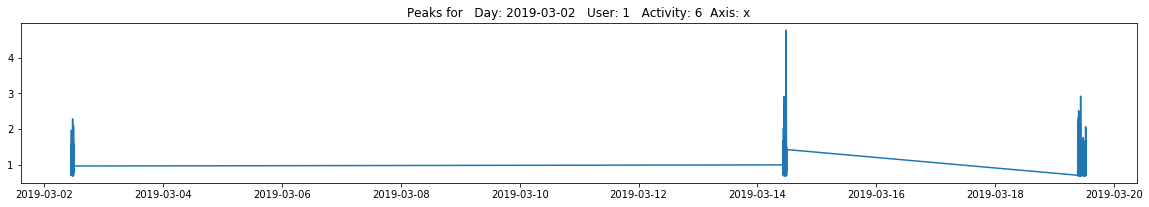

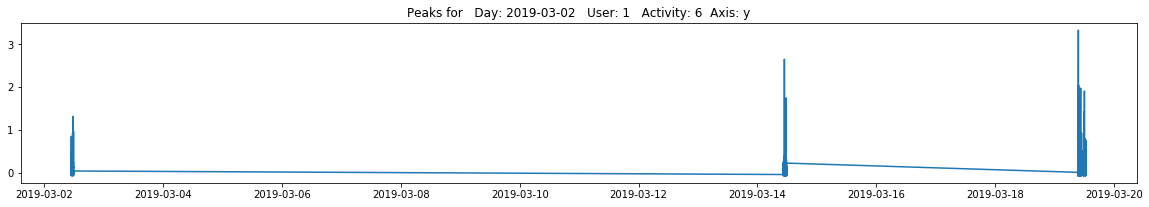

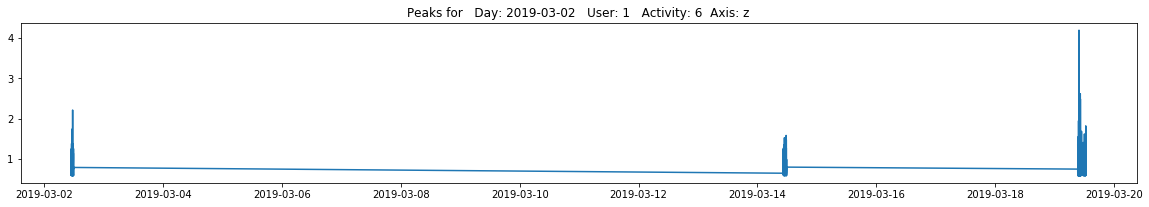

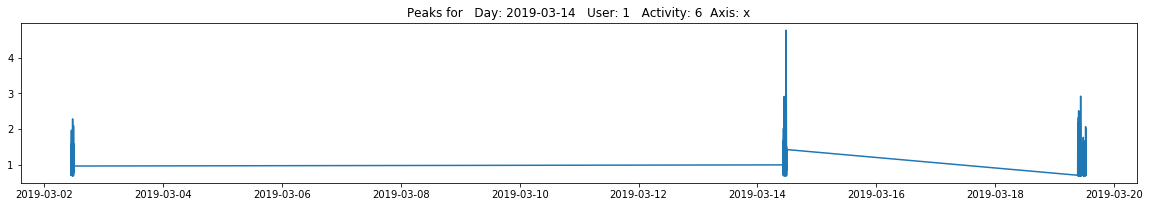

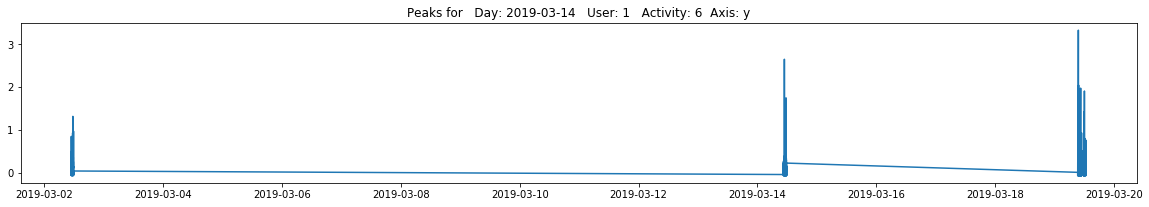

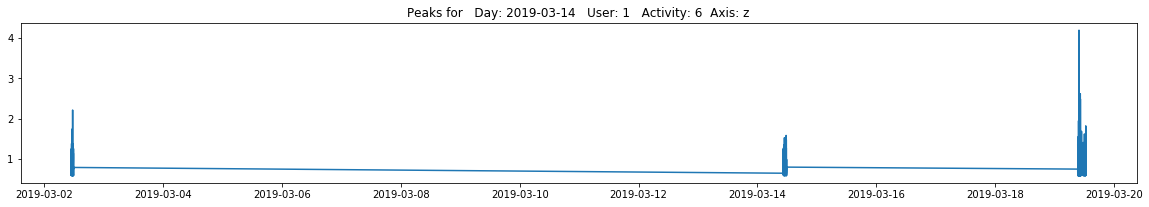

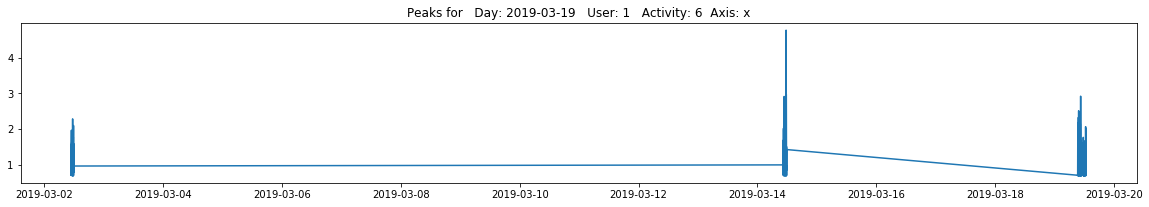

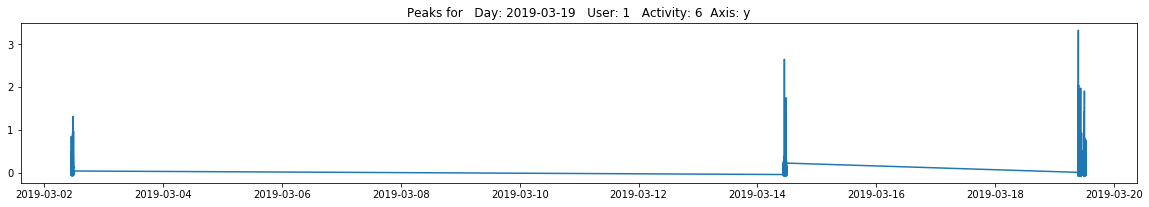

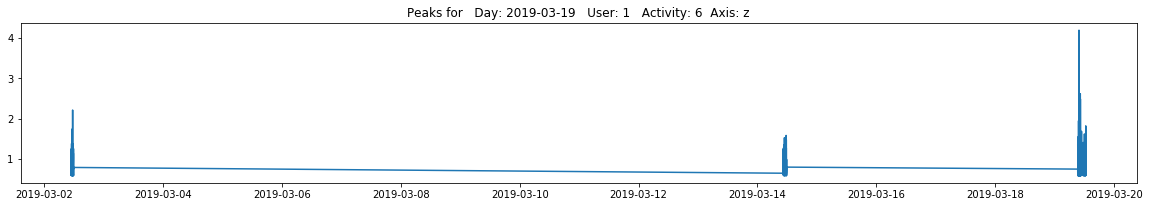

In [74]:
plotStatistics([1],[6])

# Still to include Means and other things in this function from HAR-Copy4